In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import glob
import io
import imageio.v2 as imageio
import os
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

def visualize_mnist_grid(data_loader, num_samples=25, num_rows=5):
    # Create an iterator from the data loader
    data_iterator = iter(data_loader)

    # Get a batch of images and labels
    images, labels = next(data_iterator)

    # Display the images in a grid
    fig, axes = plt.subplots(num_rows, num_samples // num_rows, figsize=(12, 8))

    for i in range(num_samples):
        row, col = i // (num_samples // num_rows), i % (num_samples // num_rows)
        ax = axes[row, col]
        image = images[i].numpy().squeeze()
        label = labels[i].item()

        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

# Run this to use GPU
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

from logging import root
class GarbageDataset(Dataset):

    def __init__(self, transform=None):
        """
        Arguments:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = '/content/drive/MyDrive/archive.zip (Unzipped Files)/Garbage classification/Garbage classification'
        self.cardboard_dir = self.root_dir + '/cardboard'
        self.glass_dir = self.root_dir + '/glass'
        self.metal_dir = self.root_dir + '/metal'
        self.paper_dir = self.root_dir + '/paper'
        self.plastic_dir = self.root_dir + '/plastic'
        self.trash_dir = self.root_dir + '/trash'
        self.combined_data = glob.glob(os.path.join(self.root_dir,'*','*.jpg'))
        self.transform = transform
        self.name_map = { 'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5 }

    def __len__(self):
        return len(self.combined_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.combined_data[idx]
        image = imageio.imread(img_name).astype(np.float32)
        img_id = self.name_map[img_name.split('/')[7]]
        sample = [image, img_id]

        if self.transform:
            sample = self.transform(sample)

        return sample

#transform = transforms.Compose([transforms.ToTensor(),transforms.RandomResizedCrop(size=(24, 24))])
transform = transforms.Compose([transforms.ToTensor()])
#trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainset = GarbageDataset()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Visualize a grid of 25 samples from the garbage dataset
#visualize_mnist_grid(trainloader, num_samples=25, num_rows=5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu


##Fully Connected Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dim = 512 * 384 * 3
        self.fc1 = nn.Linear(self.dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = x.view(-1, self.dim)  # Flatten the input
        x = F.relu(self.fc1(x))  # ReLU Linear Layer
        x = F.relu(self.fc2(x))  # ReLU Linear Layer
        x = self.fc3(x)  # Linear Layer
        return x

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [ ]:
for epoch in range(100):  # You can adjust the number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

In [ ]:
"""
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Accuracy on the test set: 94.19%


In [ ]:
filename = "fully_connected_e100.pth"

net = net.to("cpu")
torch.save(net.state_dict(),filename)

##Convolutional Neural Network

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 64, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 128, 1)
        self.pool4 = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(256, 32) #Changed to match shape
        self.fc2 = nn.Linear(32, 6)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2) #Added to reshape data properly
        x = self.pool1(F.relu(self.conv1(x))) # Conv ReLU Pool
        x = self.pool2(F.relu(self.conv2(x))) # Conv ReLU Pool
        x = self.pool3(F.relu(self.conv3(x))) # Conv ReLU Pool
        x = self.pool3(F.relu(self.conv3(x))) # Conv ReLU Pool
        x = self.pool3(F.relu(self.conv3(x))) # Conv ReLU Pool
        x = self.pool3(F.relu(self.conv3(x))) # Conv ReLU Pool
        x = self.pool4(F.relu(self.conv4(x))) # Conv ReLU Pool
        x = x.reshape(-1, 256) #Changed from "x.view(-1, 256)"
        x = F.relu(self.fc1(x)) # ReLU Linear Layer
        x = self.fc2(x) # Linear Layer
        return x


try:
  del net
  del loss
except:
  pass

torch.cuda.empty_cache()
net = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
for epoch in range(10):  # You can adjust the number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

Epoch 1, Loss: 1.7234584778547286
Epoch 2, Loss: 1.6981065273284912
Epoch 3, Loss: 1.602803072333336
Epoch 4, Loss: 1.4282032310962678
Epoch 5, Loss: 1.36719608604908
Epoch 6, Loss: 1.3026127249002457
Epoch 7, Loss: 1.2647073566913605
Epoch 8, Loss: 1.1947712004184723
Epoch 9, Loss: 1.1514584124088287
Epoch 10, Loss: 1.0966570198535919


### Evaluate our performance on the test dataset

Next, we create a new dataloader for the MNIST Test Set and run an evaluation of our trained neural network.

**Report your accuracy on the test set**

In [ ]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Accuracy on the test set: 99.13%


### Save our model parameters

We can save our model parameters to a specific file name.

Make sure to save these weights to your local drive.

In [ ]:
filename = "convolutional.pth"

net = net.to("cpu")
torch.save(net.state_dict(),filename)

## Question 4: Train with data augmentation

Finally we train a Convolutional Neural Network, but this time we create variation in our training data using data augmentation.

We will use a crop augmentation which will randomly crop the training images and rescale them so that the neural network is resistant to scale changes in the numbers.

Below we declare and then visualize the augmented dataset.

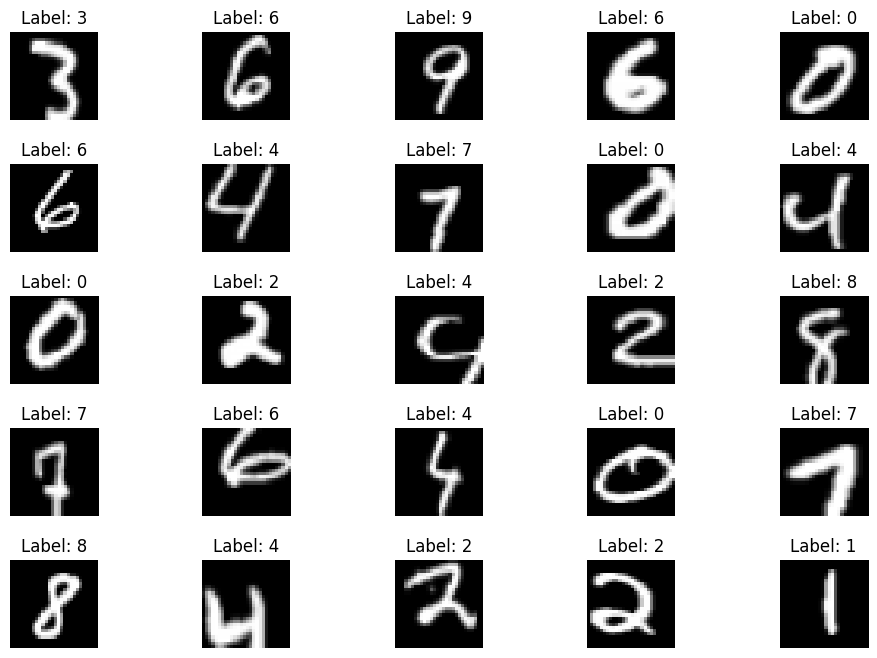

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.RandomResizedCrop(size=(28, 28),scale=(0.4,1.0))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Visualize a grid of 25 samples from the MNIST dataset
visualize_mnist_grid(trainloader, num_samples=25, num_rows=5)

### Train and Evaluation

We go through the training process using the same convolutional network architecture we used in Question 3.

**Report the accuracy on the test set.**

**Compared to the previous networks, how is the accuracy different? Why do you think this is so?**

In [ ]:
# Re-declare the CNN object, the loss, and the optimizer
try:
  del net
  del loss
except:
  pass

torch.cuda.empty_cache()
net = CNN()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Run the training
for epoch in range(10):  # You can adjust the number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Evaluate on the test set
transform = transforms.Compose([transforms.ToTensor()]) # remove the data augmentation transformation
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total}%')

Epoch 1, Loss: 0.6198504070229114
Epoch 2, Loss: 0.25809562807557174
Epoch 3, Loss: 0.19113122458968843
Epoch 4, Loss: 0.16078417735503936
Epoch 5, Loss: 0.14168485284927906
Epoch 6, Loss: 0.12974561053389774
Epoch 7, Loss: 0.12322548593976286
Epoch 8, Loss: 0.11653583931293823
Epoch 9, Loss: 0.11060112785559886
Epoch 10, Loss: 0.10122443717181571
Accuracy on the test set: 98.8%


### Save the model

We can save our model parameters to a specific file name.

Make sure to save these weights to your local drive.

In [ ]:
filename = "data_augmentation.pth"

net = net.to("cpu")
torch.save(net.state_dict(),filename)